In [67]:
import json
from typing import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.fft import fft, fftfreq
from scipy.integrate import cumtrapz
from scipy.signal import spectrogram, welch, butter, sosfilt, find_peaks, lfilter, filtfilt, iirnotch

import biosignalsnotebooks as bsnb

In [68]:
def data_prepare(filename: str, low_pass: int=10, sfreq: int=1000, high_band: int=20, low_band: int=450) -> Tuple[np.ndarray, np.ndarray, Dict]:
    # Read data and correction to 3.3v
    df = pd.read_csv(f"{filename}.csv")
    values = df.to_numpy()
    time = values[:, 0]
    data = values[:, 1:] * 3.3 / 65535
    
    with open(f"{filename}_points.json", "r") as f:
        points = json.load(f)

    # Remove basline mean
    baseline_idx = np.argwhere(time >= points["baseline"])[0][0]
    baseline = data[:baseline_idx, :]
    x0 = np.mean(baseline, axis=0)

    normalize = data - x0
    yf = np.argwhere(time >= 22)[0][0]

    time = time[baseline_idx:yf]
    data_removed_mean = normalize[baseline_idx:yf, :]

    # create bandpass filter for EMG
    high = high_band/(sfreq/2)
    low = low_band/(sfreq/2)
    b, a = butter(4, [high, low], btype='bandpass')
    data_filtered = np.vstack([filtfilt(b, a, data_removed_mean[:, i]) for i in range(data_removed_mean.shape[1])]).T

    # notch filter
    b_notch, a_notch = iirnotch(50.0, 30.0, sfreq)
    data_notched = np.vstack([filtfilt(b_notch, a_notch, data_filtered[:, i]) for i in range(data_filtered.shape[1])]).T

    # rectify emg signal
    data_rectified = abs(data_notched)

    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/(sfreq/2)
    b2, a2 = butter(4, low_pass, btype='lowpass')
    data_envelope = np.vstack([filtfilt(b2, a2, data_rectified[:, i]) for i in range(data_rectified.shape[1])]).T

    return time, data_envelope, points

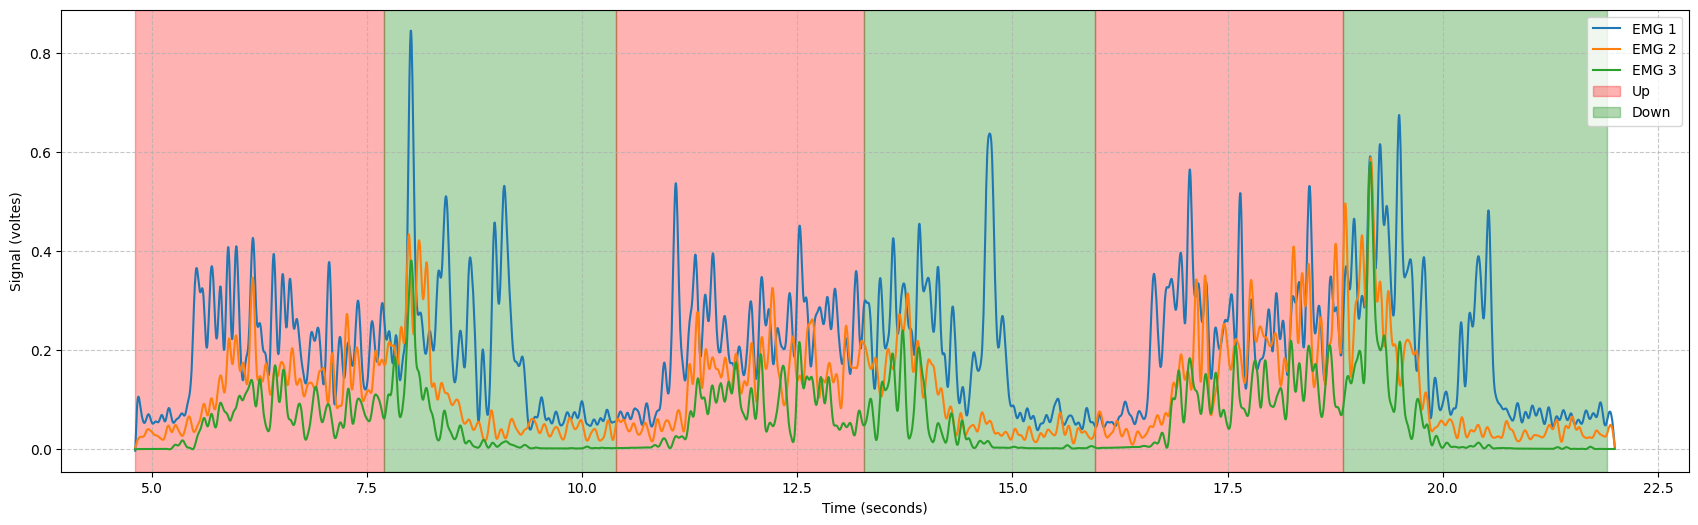

In [69]:
interval, emg, config = data_prepare("../data/sitting/exp_10", low_pass=40)

plt.figure(figsize=(21, 6))
plt.plot(interval, emg[:, 0], label="EMG 1")
plt.plot(interval, emg[:, 1], label="EMG 2")
plt.plot(interval, emg[:, 2], label="EMG 3")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (voltes)")
c = ["r", "g"]
periods = []
for i in range(3):
    t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
    tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
    periods.extend([t0, tf])
periods.append(np.argwhere(interval >= 21.9)[0][0])
for i in range(len(periods) - 1):
    if i in [0, 1]:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3, label=f"{'Up' if i%2==0 else 'Down'}")
    else:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3)
plt.legend()
plt.savefig("preprocessed_signals.png")
# plt.show()

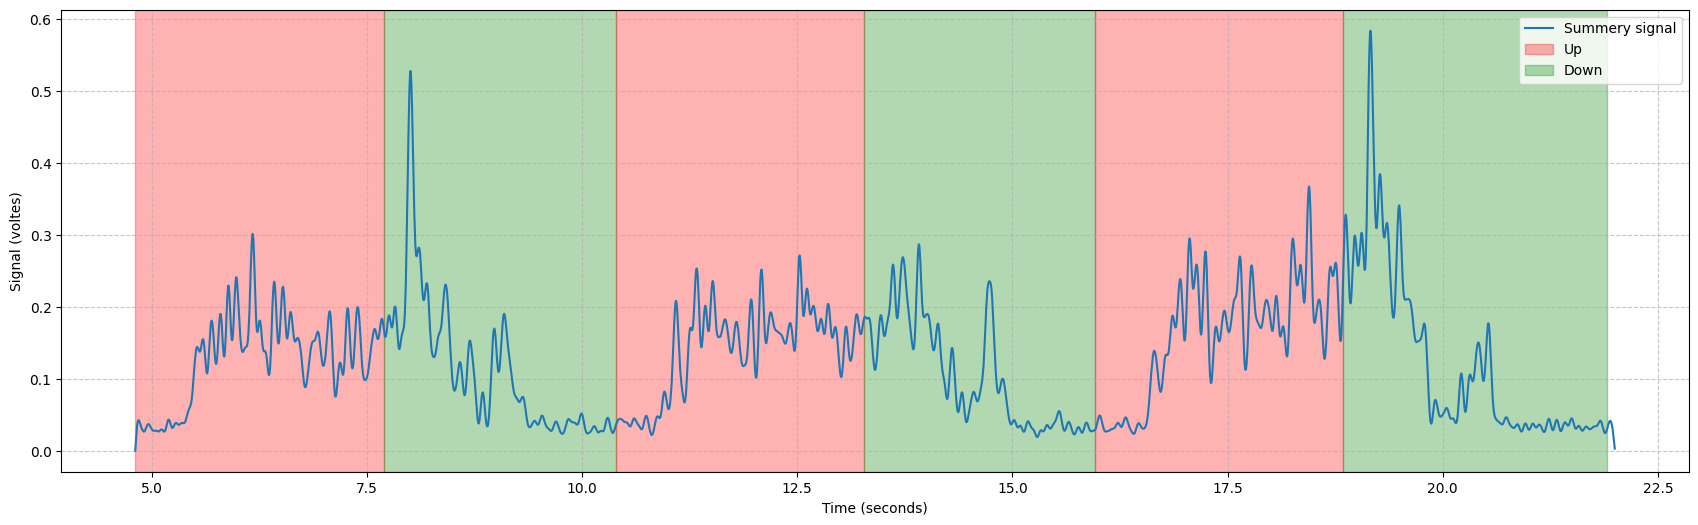

In [70]:
plt.figure(figsize=(21, 6))
plt.plot(interval, np.sum(emg, axis=1) / 3, label="Summery signal")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (voltes)")
c = ["r", "g"]
periods = []
for i in range(3):
    t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
    tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
    periods.extend([t0, tf])
periods.append(np.argwhere(interval >= 21.9)[0][0])
for i in range(len(periods) - 1):
    if i in [0, 1]:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3, label=f"{'Up' if i%2==0 else 'Down'}")
    else:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3)
plt.legend()
plt.savefig("preprocessed_summery_signal.png")
# plt.show()

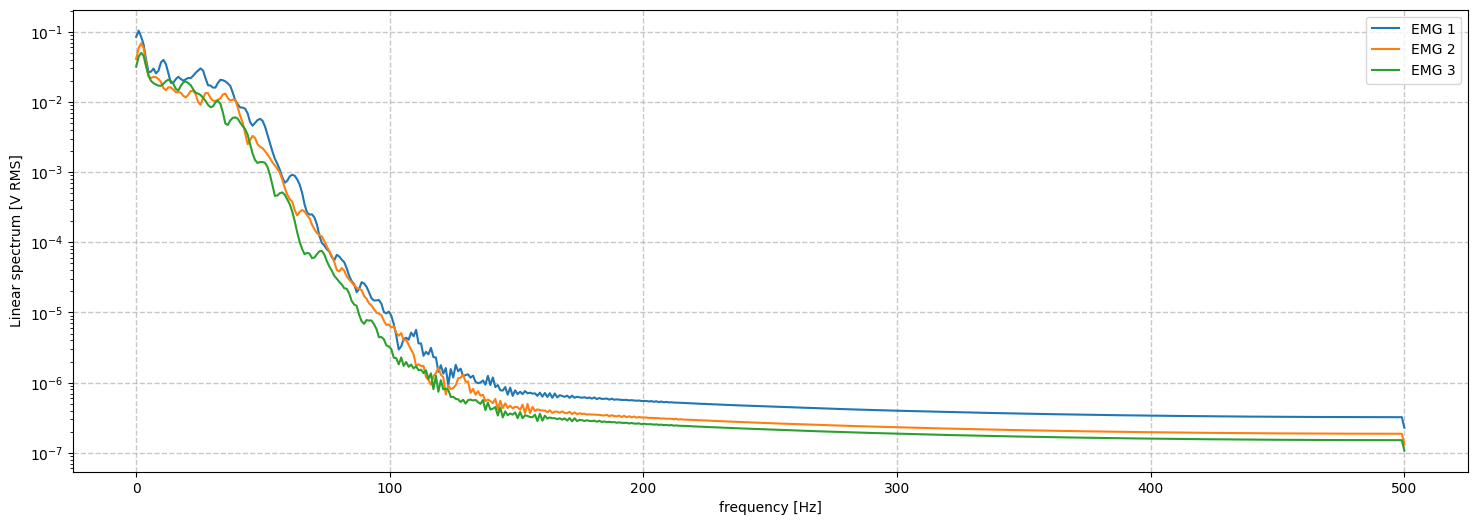

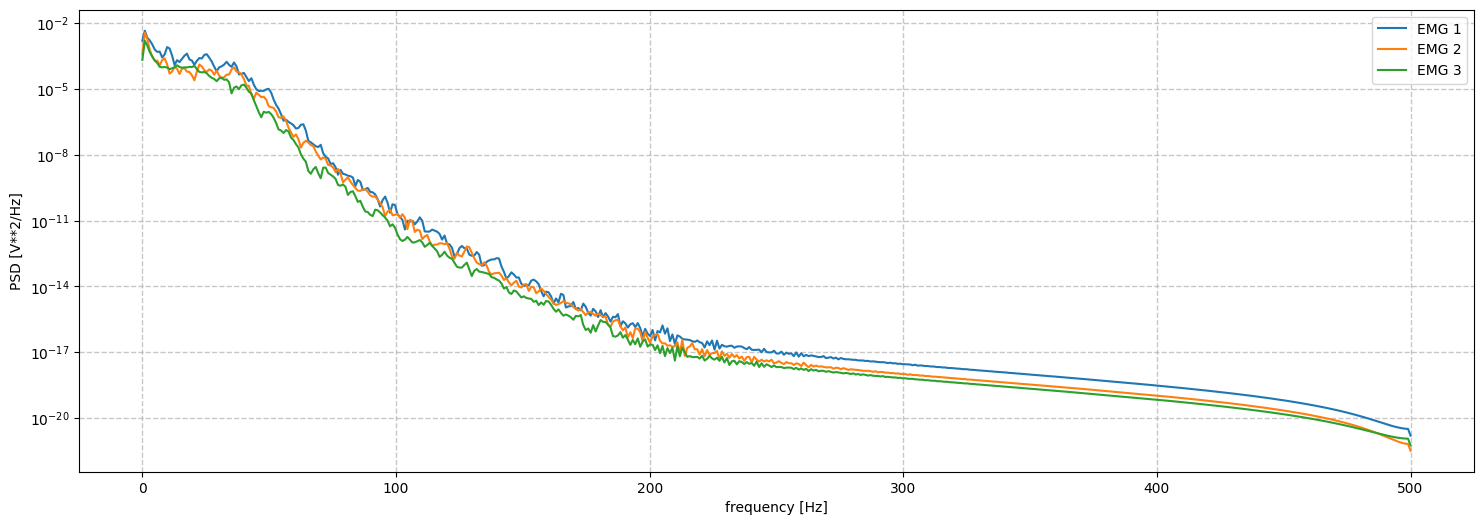

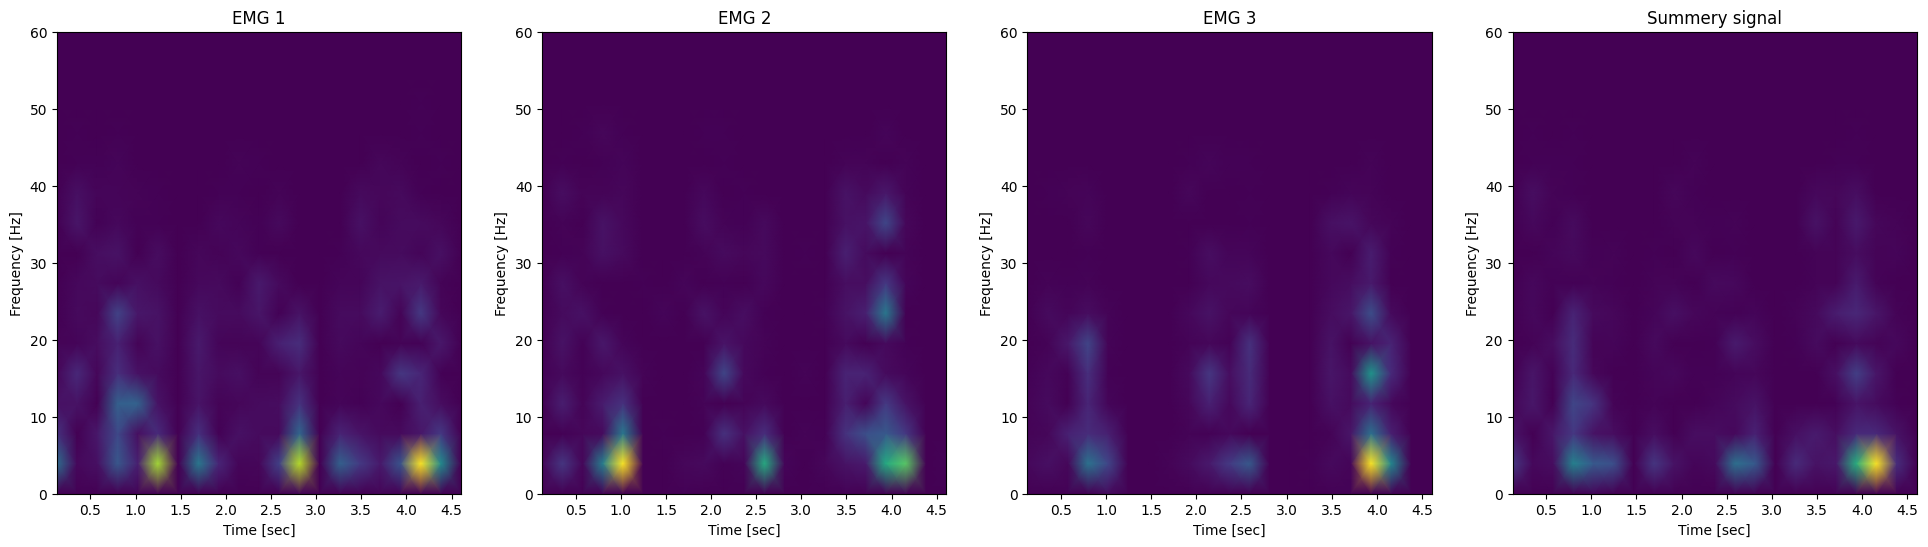

In [71]:
plt.figure(figsize=(18, 6))
for i in range(emg.shape[1]):
    f, pxx = welch(emg[:, i], 1000, "flattop", 1024, scaling='spectrum')
    plt.semilogy(f, np.sqrt(pxx), label=f"EMG {i+1}")
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.7)
plt.legend()
plt.savefig("linear_spectrum.png")
# plt.show()

plt.figure(figsize=(18, 6))
for i in range(emg.shape[1]):
    f, pxx = welch(emg[:, i], 1000, nperseg=1024, scaling='spectrum')
    plt.semilogy(f, pxx, label=f"EMG {i+1}")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.7)
plt.legend()
plt.savefig("psd.png")
# plt.show()


fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for i in range(emg.shape[1]):
    f, t, Sxx = spectrogram(emg[:, i], 1000)
    axes[i].set_title(f"EMG {i + 1}")
    axes[i].pcolormesh(t, f, Sxx, shading='gouraud')
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_xlabel('Time [sec]')
    axes[i].set_ylim([0, 60])
f, t, Sxx = spectrogram(np.sum(emg, axis=1) / 3, 1000)
axes[3].set_title(f"Summery signal")
axes[3].pcolormesh(t, f, Sxx, shading='gouraud')
axes[3].set_ylabel('Frequency [Hz]')
axes[3].set_xlabel('Time [sec]')
axes[3].set_ylim([0, 60])
plt.savefig("spectrograms.png")
# plt.show()

In [72]:
def analyze(signal: np.ndarray, fs: int = 1000) -> None:
    # Root Mean Square
    rms = np.sqrt(np.sum(np.power(signal, 2)) / signal.shape[0])

    # Signal Power Spectrum
    f, P = welch(signal, fs=fs, window='hann', noverlap=0, nfft=int(256.))
    # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]

    print ('Root Mean Square: ', rms,'mV')
    print ('Total Power: ', total_power)
    print ('Median Frequency: ', median_freq,'Hz')
    print ('Maximum Power Frequency: ', f_max, 'Hz')
    bsnb.plot_emg_spect_freq(f, P, f_max, median_freq)

In [73]:
analyze(emg[:, 0])
analyze(emg[:, 1])
analyze(emg[:, 2])
analyze(np.sum(emg, axis=1) / 3)

Root Mean Square:  0.24140217948744921 mV
Total Power:  0.008525572774900458
Median Frequency:  11.71875 Hz
Maximum Power Frequency:  3.90625 Hz


Root Mean Square:  0.1508199045709626 mV
Total Power:  0.0026960032275081913
Median Frequency:  15.625 Hz
Maximum Power Frequency:  3.90625 Hz


Root Mean Square:  0.08937164524715108 mV
Total Power:  0.0019940739077807237
Median Frequency:  11.71875 Hz
Maximum Power Frequency:  3.90625 Hz


Root Mean Square:  0.15264810590389943 mV
Total Power:  0.0024500624267419823
Median Frequency:  11.71875 Hz
Maximum Power Frequency:  3.90625 Hz


In [74]:
_ = bsnb.detect_emg_activations(emg[:, 0], 1000, smooth_level=20, threshold_level=10, time_units=True, plot_result=True)
_ = bsnb.detect_emg_activations(emg[:, 1], 1000, smooth_level=20, threshold_level=10, time_units=True, plot_result=True)
_ = bsnb.detect_emg_activations(emg[:, 2], 1000, smooth_level=20, threshold_level=10, time_units=True, plot_result=True)
_ = bsnb.detect_emg_activations(np.sum(emg, axis=1) / 3, 1000, smooth_level=20, threshold_level=10, time_units=True, plot_result=True)